# Enhancing Language Understanding: Unleashing the Power of RNN, LSTM, GRU, and Bidirectional RNN for POS Tagging

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')


[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:

# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [4]:
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

In [5]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [6]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))

In [7]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [8]:
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [9]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


# Vectorize X and Y

### Encoding X and Y to integer values

In [10]:
#from tensorflow.keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [11]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [12]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [13]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print('{} sentences have disparate input output lengths.'.format(sum(different_length)))

0 sentences have disparate input output lengths.


# Pad Sequences

In [14]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


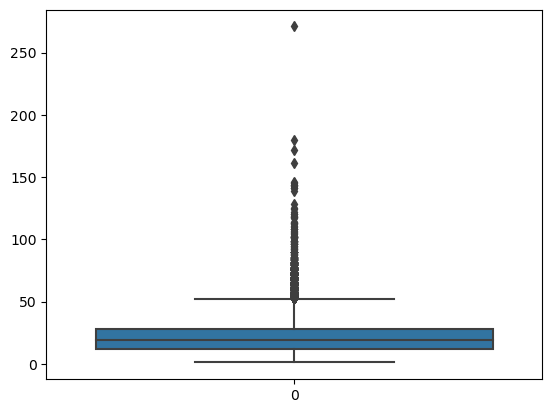

In [15]:
sns.boxplot(lengths)
plt.show()

In [16]:
MAX_SEQ_LENGTH = 100

X_padded = pad_sequences(X_encoded, maxlen = MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(Y_encoded, maxlen = MAX_SEQ_LENGTH, padding='pre', truncating='post')

In [17]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [18]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

# Word embeddings

In [19]:
# word2vec download link (Size ~ 1.5GB): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

path = '/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin'
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [20]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [21]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [22]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [23]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

In [24]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['women']]

array([-1.39648438e-01,  1.64062500e-01,  1.61132812e-02,  1.07910156e-01,
        2.18750000e-01, -2.63671875e-01, -1.13281250e-01, -1.19628906e-01,
       -6.68945312e-02,  9.61914062e-02, -1.21093750e-01, -1.71875000e-01,
        1.23046875e-01,  1.93359375e-01, -2.99072266e-02,  1.51367188e-01,
       -1.13769531e-01,  1.46484375e-02, -5.58471680e-03,  1.10351562e-01,
       -1.64062500e-01,  3.24707031e-02, -1.09863281e-01, -3.41796875e-01,
       -1.45507812e-01, -2.09960938e-01, -1.82617188e-01,  1.78710938e-01,
       -1.31835938e-01, -1.76757812e-01,  2.42614746e-03, -2.53906250e-02,
       -1.73828125e-01, -1.86523438e-01, -4.05273438e-02,  9.91210938e-02,
       -6.00585938e-02, -1.35742188e-01, -6.59179688e-02,  1.26953125e-01,
       -6.29882812e-02,  9.96093750e-02,  5.17578125e-02, -4.44335938e-02,
       -1.62353516e-02, -9.42382812e-02, -7.42187500e-02, -2.92968750e-02,
        1.78710938e-01,  1.23046875e-01,  2.51953125e-01, -9.08203125e-02,
       -1.76239014e-03,  

# Use one-hot encoding for output sequences (Y)

In [25]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [26]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 100, 13)


## Split data in training, validation and tesing sets

In [27]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [28]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [29]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X: (#samples, #timesteps, #features)

Shape of Y: (#samples, #timesteps, #features)

![RNN tensor shape](./jupyter resources/rnn_tensor.png)

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

we will try the following three RNN models:

* RNN with arbitrarily initialised, untrainable embeddings: In this model, we will initialise the embedding weights arbitrarily. Further, we'll freeze the embeddings, that is, we won't allow the network to train them. 
* RNN with arbitrarily initialised, trainable embeddings: In this model, we'll allow the network to train the embeddings.
* RNN with trainable word2vec embeddings: In this experiment, we'll use word2vec word embeddings and also allow the network to train them further.
 

Let's start with the first experiment: an RNN with arbitrarily initialised, untrainable embeddings.


# 1. Vanilla RNN

**Uninitialised fixed embeddings**

First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [30]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [31]:
# create architecture

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

# Compile model

In [32]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [33]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


# Fit model

In [34]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 33s 76ms/step - loss: 0.5051 - acc: 0.8540 - val_loss: 0.3397 - val_acc: 0.8999
Epoch 2/10
408/408 [==============================] - 28s 68ms/step - loss: 0.2804 - acc: 0.9164 - val_loss: 0.2351 - val_acc: 0.9285
Epoch 3/10
408/408 [==============================] - 28s 70ms/step - loss: 0.2127 - acc: 0.9349 - val_loss: 0.1923 - val_acc: 0.9401
Epoch 4/10
408/408 [==============================] - 28s 69ms/step - loss: 0.1816 - acc: 0.9428 - val_loss: 0.1694 - val_acc: 0.9460
Epoch 5/10
408/408 [==============================] - 29s 70ms/step - loss: 0.1627 - acc: 0.9479 - val_loss: 0.1541 - val_acc: 0.9500
Epoch 6/10
408/408 [==============================] - 29s 70ms/step - loss: 0.1497 - acc: 0.9515 - val_loss: 0.1435 - val_acc: 0.9533
Epoch 7/10
408/408 [==============================] - 29s 71ms/step - loss: 0.1405 - acc: 0.9541 - val_loss: 0.1359 - val_acc: 0.9552
Epoch 8/10
408/408 [==============================] - 29s 71ms

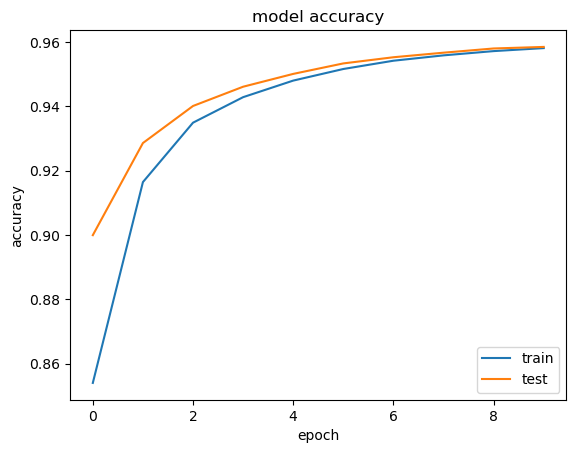

In [35]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 2. Uninitialised trainable embeddings

In [36]:
# create architecture

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                    # True - update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [37]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [38]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


In [39]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 149s 361ms/step - loss: 0.2091 - acc: 0.9504 - val_loss: 0.0411 - val_acc: 0.9877
Epoch 2/10
408/408 [==============================] - 146s 358ms/step - loss: 0.0299 - acc: 0.9904 - val_loss: 0.0296 - val_acc: 0.9897
Epoch 3/10
408/408 [==============================] - 144s 353ms/step - loss: 0.0208 - acc: 0.9928 - val_loss: 0.0277 - val_acc: 0.9901
Epoch 4/10
408/408 [==============================] - 144s 354ms/step - loss: 0.0173 - acc: 0.9939 - val_loss: 0.0271 - val_acc: 0.9904
Epoch 5/10
408/408 [==============================] - 145s 355ms/step - loss: 0.0148 - acc: 0.9948 - val_loss: 0.0275 - val_acc: 0.9904
Epoch 6/10
408/408 [==============================] - 145s 355ms/step - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0288 - val_acc: 0.9903
Epoch 7/10
408/408 [==============================] - 145s 355ms/step - loss: 0.0106 - acc: 0.9964 - val_loss: 0.0305 - val_acc: 0.9899
Epoch 8/10
408/408 [============================

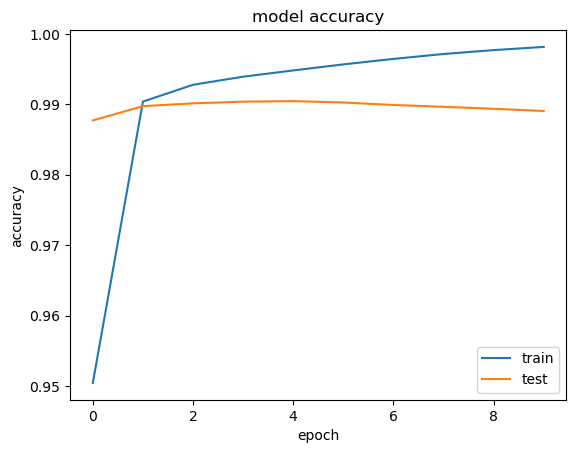

In [40]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# Using pre-trained embedding weights

In [41]:
# create architecture

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                    # True - update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile Model

In [42]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [43]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit Model

In [44]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 147s 356ms/step - loss: 0.1778 - acc: 0.9613 - val_loss: 0.0353 - val_acc: 0.9890
Epoch 2/10
408/408 [==============================] - 146s 357ms/step - loss: 0.0269 - acc: 0.9910 - val_loss: 0.0271 - val_acc: 0.9905
Epoch 3/10
408/408 [==============================] - 146s 358ms/step - loss: 0.0198 - acc: 0.9930 - val_loss: 0.0255 - val_acc: 0.9910
Epoch 4/10
408/408 [==============================] - 145s 356ms/step - loss: 0.0169 - acc: 0.9940 - val_loss: 0.0250 - val_acc: 0.9912
Epoch 5/10
408/408 [==============================] - 147s 359ms/step - loss: 0.0148 - acc: 0.9947 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 6/10
408/408 [==============================] - 147s 361ms/step - loss: 0.0130 - acc: 0.9954 - val_loss: 0.0257 - val_acc: 0.9912
Epoch 7/10
408/408 [==============================] - 147s 359ms/step - loss: 0.0114 - acc: 0.9960 - val_loss: 0.0265 - val_acc: 0.9911
Epoch 8/10
408/408 [============================

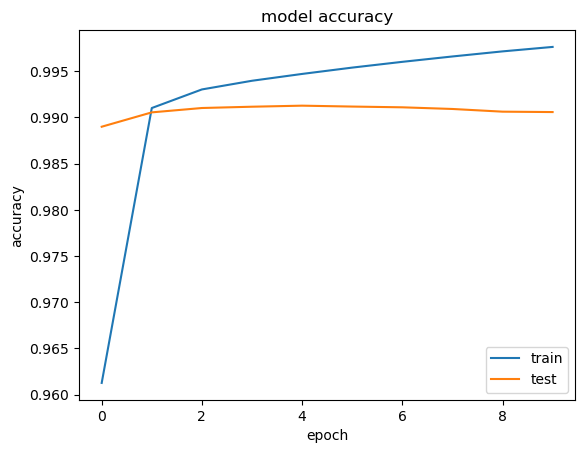

In [45]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 2. LSTM Model

In [46]:
# create architecture

lstm_model = Sequential()

lstm_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                    # True - update the embeddings
))

# add an RNN layer which contains 64 RNN cells
lstm_model.add(LSTM(64, return_sequences=True))

# add time distributed (output at each sequence) layer
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

# Compile Model

In [47]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [48]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


In [49]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 184s 444ms/step - loss: 0.3101 - acc: 0.9293 - val_loss: 0.0483 - val_acc: 0.9875
Epoch 2/10
408/408 [==============================] - 181s 445ms/step - loss: 0.0340 - acc: 0.9897 - val_loss: 0.0296 - val_acc: 0.9900
Epoch 3/10
408/408 [==============================] - 181s 443ms/step - loss: 0.0235 - acc: 0.9919 - val_loss: 0.0262 - val_acc: 0.9906
Epoch 4/10
408/408 [==============================] - 181s 444ms/step - loss: 0.0200 - acc: 0.9928 - val_loss: 0.0250 - val_acc: 0.9909
Epoch 5/10
408/408 [==============================] - 180s 442ms/step - loss: 0.0179 - acc: 0.9935 - val_loss: 0.0243 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 180s 442ms/step - loss: 0.0164 - acc: 0.9940 - val_loss: 0.0240 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 179s 439ms/step - loss: 0.0150 - acc: 0.9945 - val_loss: 0.0238 - val_acc: 0.9915
Epoch 8/10
408/408 [============================

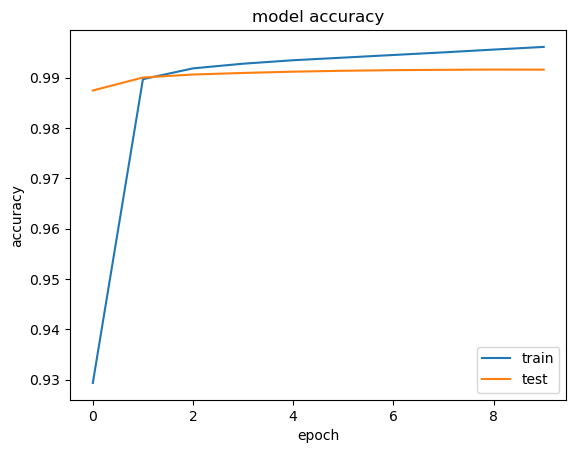

In [50]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 3. GRU Model

In [51]:
# create architecture

GRU_model = Sequential()

GRU_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                    # True - update the embeddings
))

# add an RNN layer which contains 64 RNN cells
GRU_model.add(GRU(64, return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
GRU_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [52]:
GRU_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [53]:
GRU_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


In [54]:
GRU_training = GRU_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 171s 412ms/step - loss: 0.2172 - acc: 0.9598 - val_loss: 0.0346 - val_acc: 0.9887
Epoch 2/10
408/408 [==============================] - 168s 412ms/step - loss: 0.0271 - acc: 0.9905 - val_loss: 0.0268 - val_acc: 0.9903
Epoch 3/10
408/408 [==============================] - 170s 418ms/step - loss: 0.0206 - acc: 0.9924 - val_loss: 0.0247 - val_acc: 0.9911
Epoch 4/10
408/408 [==============================] - 171s 418ms/step - loss: 0.0178 - acc: 0.9934 - val_loss: 0.0238 - val_acc: 0.9913
Epoch 5/10
408/408 [==============================] - 173s 423ms/step - loss: 0.0161 - acc: 0.9940 - val_loss: 0.0236 - val_acc: 0.9915
Epoch 6/10
408/408 [==============================] - 168s 412ms/step - loss: 0.0148 - acc: 0.9945 - val_loss: 0.0235 - val_acc: 0.9916
Epoch 7/10
408/408 [==============================] - 168s 411ms/step - loss: 0.0136 - acc: 0.9949 - val_loss: 0.0237 - val_acc: 0.9917
Epoch 8/10
408/408 [============================

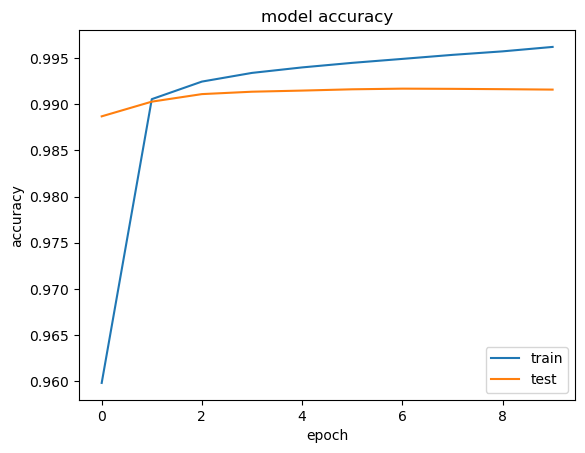

In [55]:
# visualise training history
plt.plot(GRU_training.history['acc'])
plt.plot(GRU_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### The time taken by an LSTM is greater than a GRU and an RNN. This was expected since the parameters in an LSTM and GRU are 4x and 3x of a normal RNN

# 4. Bidirectional LSTM Model

In [56]:
# create architecture

bidirect_model = Sequential()

bidirect_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                    # True - update the embeddings
))

# add an RNN layer which contains 64 RNN cells
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
)))

# add time distributed (output at each sequence) layer
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [57]:
bidirect_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [58]:
# check summary of model
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


In [59]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 246s 588ms/step - loss: 0.2360 - acc: 0.9444 - val_loss: 0.0329 - val_acc: 0.9896
Epoch 2/10
408/408 [==============================] - 238s 584ms/step - loss: 0.0242 - acc: 0.9921 - val_loss: 0.0224 - val_acc: 0.9925
Epoch 3/10
408/408 [==============================] - 239s 587ms/step - loss: 0.0164 - acc: 0.9945 - val_loss: 0.0197 - val_acc: 0.9933
Epoch 4/10
408/408 [==============================] - 237s 582ms/step - loss: 0.0129 - acc: 0.9956 - val_loss: 0.0185 - val_acc: 0.9938
Epoch 5/10
408/408 [==============================] - 236s 578ms/step - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0181 - val_acc: 0.9940
Epoch 6/10
408/408 [==============================] - 235s 576ms/step - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0181 - val_acc: 0.9942
Epoch 7/10
408/408 [==============================] - 238s 584ms/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0188 - val_acc: 0.9941
Epoch 8/10
408/408 [============================

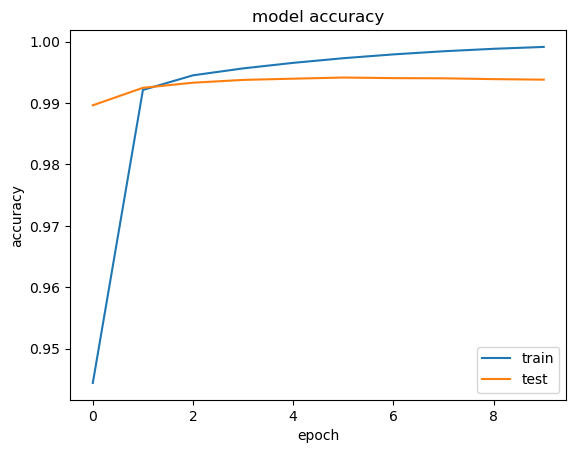

In [60]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# Model Evaluation

In [61]:
#rnn_model
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose=1)
print('Loss: {0}, \n Accuracy: {1}'.format(loss, accuracy))

339/339 [==============================] - 4s 13ms/step - loss: 0.0311 - acc: 0.9906
Loss: 0.03106437809765339, 
 Accuracy: 0.990574300289154


In [62]:
#lstm_model
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose=1)
print('Loss: {0}, \n Accuracy: {1}'.format(loss, accuracy))

339/339 [==============================] - 10s 28ms/step - loss: 0.0251 - acc: 0.9917
Loss: 0.025063537061214447, 
 Accuracy: 0.9917108416557312


In [63]:
#GRU_model
loss, accuracy = GRU_model.evaluate(X_test, Y_test, verbose=1)
print('Loss: {0}, \n Accuracy: {1}'.format(loss, accuracy))

339/339 [==============================] - 8s 23ms/step - loss: 0.0253 - acc: 0.9916
Loss: 0.025281056761741638, 
 Accuracy: 0.9915972948074341


In [64]:
#Bidirect_model
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose=1)
print('Loss: {0}, \n Accuracy: {1}'.format(loss, accuracy))

339/339 [==============================] - 14s 41ms/step - loss: 0.0227 - acc: 0.9937
Loss: 0.022708959877490997, 
 Accuracy: 0.9937143325805664
